## Gene modules comparisons

## Needed data:
* ### Assignment of genes to modules (WGCNA / MFUZZ)    

We use WGCNA to cluster genes by their RNA activity in various TRNAseq experiments, both in developmental stages and pure tissue samples. This analysis assigns each gene in a single cluster. These clusters have names like "blue". "green" etc.
We manually explore the clusters, and by determining at which experiment the genes of the cluster seem to be differentially expressed (but also by GO analysis on each cluster), we assign more meaningful names to the clusters , like "liver", "muscle" etc. The translating dictionaries are in the end of the notebook.

* ### Assignment of genome regions to genes 
    
We assign a BASAL region to each gene, it starts from its TSS and extends 5kb upstream and 1kb downstream,
or untill it encounters another TSS.
    
* ### TF Motifs mapped in the genome
* ### Grouping of genes into homology-families       

In [1]:
import gzip
import os
import pysam

from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
sns.set_style('white')
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

from collections import Counter
from functools import reduce
from operator import add


from scipy.stats import hypergeom
statf = hypergeom.sf
from math import log

from scipy.stats import pearsonr
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.metrics.pairwise import pairwise_distances as PWD


import warnings
warnings.filterwarnings('ignore')

## Preprocessing:

In [2]:
# Here we load the mapping of genes to modules from csv
# into dictionaries:
dan_cl = pd.read_csv("./data/wgcna_results/wgcna_dre_modulekey.tab.gz", sep='\t')
dan_cl.columns = ['geneID','clusterID','updown']
dan_cl_d = dict(dan_cl[['geneID','clusterID']].to_records(index=False))
bla_cl = pd.read_csv("./data/wgcna_results/wgcna_bla_modulekey.tab.gz", sep='\t')
bla_cl.columns = ['geneID','clusterID','updown']
bla_cl_d = dict(bla_cl[['geneID','clusterID']].to_records(index=False))

# bla_cl_d ~= {'BL06687': 'greenyellow',
#  'BL12105': 'greenyellow',
#  'BL18033': 'magenta',....}

In [3]:
# we load the gene family bindings into a dictionary where 
# key = geneID
# value =  unique gene family number (some integer)
gfams = (pd
            .read_csv("./data/gene_families_table.tsv.gz",
                     sep='\t')
            .applymap(lambda c: c.split(':') if c==c else []))

gfamsC = gfams.applymap(lambda c: len(c))

gfamsD = {}
for rowi, row in gfams.iterrows():
    for species in ['Bla','Dre','Mmu','Hsa','Dme']:
        for gene in row[species]:
            gfamsD[gene] = int(rowi)
fam_of = {}
for rowi,row in gfams[['Bla']].dropna().iterrows():
    for gene in row.Bla:
        fam_of[gene]= rowi
for rowi,row in gfams[['Dre']].dropna().iterrows():
    for gene in row.Dre:
        fam_of[gene]= rowi
# fam_of maps all genes to their gene family ID

In [5]:
### translate the uninformative color names to manually made informative names for each module
### Cleaner versions of these dictionaries at the bottom of the notebook
transA = {'black' : '32 cells','blue' : 'N.tube(neurotrans.)','brown' : 'Gills','cyan' : 'N.tube(neurogen.)','darkmagenta' : 'Ovary/ Testis(translation)','darkorange' : 'Cilium','darkred' : 'Muscle','darkseagreen4' : '8-36hpf embryo/ Skin/ Cirri(memb. synt.)','darkslateblue' : '8hpf embryo(transcription, spliceosome)','darkturquoise' : '36hpf embryo','green' : 'Eggs/ 32 cells(cell cycle)','greenyellow' : 'Hepatic(lipid catabolism)','lavenderblush3' : 'Cirri / PreMet. / Muscle - actomyosin','lightpink4' : '15hpf embryo','magenta' : 'Skin','navajowhite2' : 'Immune','palevioletred3' : 'Ovary/ Eggs','pink' : 'Gut','plum1' : 'Gut/ Hepatic','plum2' : 'Proteasome','red' : 'PreMet.larvae','salmon' : 'Cirri(memb. synt.)','sienna3' : 'Hepatic','thistle2' : 'Gills/ PreMet larvae',
'turquoise' : 'Mitochondrion'}
transZ = {'bisque4' : "larvae 7d melanin",'black' : "Ovary/ Sperm",'blue' : "Brain",'brown' : "Cilium",'brown4' : "Liver(carboxi.met./ lipid trans)",'coral2' : "Mitochondrion",'darkgreen' : "Intestine",'darkgrey' : "RNA, ribosome, proteasome",'darkmagenta' : "Translation, ribosome, RNA bin.",'darkorange' : "Muscle",'darkred' : "Liver(oxi-red.proc./ hemostasis)",'darkseagreen4' : "12-26hpf embryo/ Skin",'darkslateblue' : "Immune",'green' : "Spliceosome",'honeydew1' : "12-26hpf embryo",'ivory' : "Eye",'lightcyan' : "Heart",'lightgreen' : "Pancreas/ Testis",'magenta' : "Gills",'pink' : "Skin",
    'salmon' : "20-26hpf embryo",'yellow4' : "Kidney",
'yellowgreen' : "Gills/ Skin"}

In [6]:
# We compute the upper tail of the hypergeometric distribution
# (survival function) for each pair of modules as a metric of enrichment

gimme_fams = lambda g: [fam_of.get(x) for x in g.geneID.tolist()]
# Population size:
gene_POP = len(gfams)

PVS = pd.DataFrame()
# for each module in zebra
for gn,g  in dan_cl.groupby('clusterID'):
    # for each module in amphioxus:
    for bgn,bg  in bla_cl.groupby('clusterID'):
        
        fams = set(gimme_fams(g))
        bfams = set(gimme_fams(bg))
        
        gene_SS = len(fams) # Sample Size
        gene_SIP = len(bfams) # Success in Population
        gene_SIS = len(bfams.intersection(fams)) # success in sample
        
        if gene_SIS>0:
            # statf is the survival function of the hypergeometric distribution            
            fish = statf(gene_SIS,  gene_POP,  gene_SS, gene_SIP)
        else:
            fish =1 
            
        PVS.loc[transZ[gn], transA[bgn]] = fish

## The gene-based heatmap

In [7]:
# we get the -log transformation of the pvalues, clip them to a workable range
mPVS = PVS.applymap(lambda x: -log(x,10) ).copy().clip(upper=25,lower=0)

# We will compute the clustering outselves in order to be able to re-use it,
# and to have better control
# we cluster by row and by column, based on euclidean distance and complete method:
linkage_HG_rows = hc.linkage(sp.distance.squareform(PWD(  mPVS.values, metric='euclidean'), checks=False), method='complete')
linkage_HG_cols = hc.linkage(sp.distance.squareform(PWD(  mPVS.T.values, metric='euclidean'), checks=False), method='complete')

# Calculating the clustering like this, allows us to use the same clustering later on

Text(0.5,1,'Enrichment for orthologous genes')

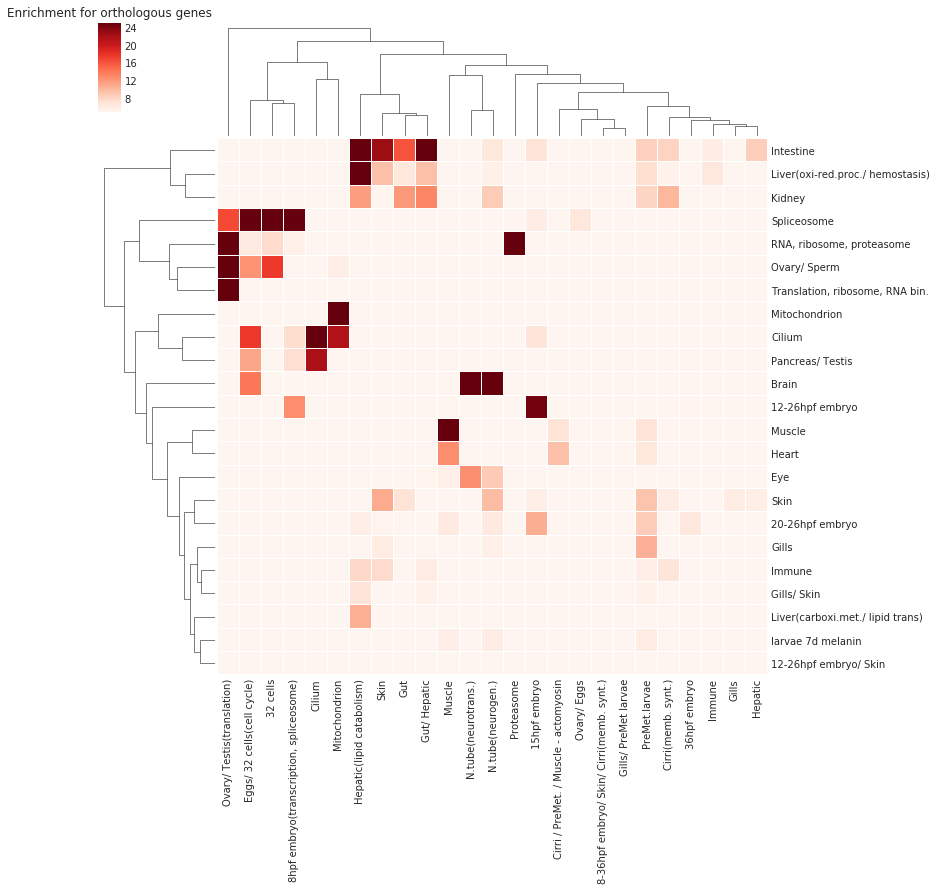

In [8]:
# Finally we plot this as a clustered heatmap
geneHM = sns.clustermap( mPVS,
                      row_linkage = linkage_HG_rows,
                      col_linkage = linkage_HG_cols,
                      linewidths=0.01,
                      figsize =(12,12),
                      cmap='Reds',
                      vmax=25, vmin=5

                      )

_ = plt.setp(geneHM.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.title('Enrichment for orthologous genes')

In [10]:
transA = {
'black' : '32 cells',
'blue' : 'N.tube(neurotrans.)',
'brown' : 'Gills',
'cyan' : 'N.tube(neurogen.)',
'darkmagenta' : 'Ovary/ Testis(translation)',
'darkorange' : 'Cilium',
'darkred' : 'Muscle',
'darkseagreen4' : '8-36hpf embryo/ Skin/ Cirri(memb. synt.)',
'darkslateblue' : '8hpf embryo(transcription, spliceosome)',
'darkturquoise' : '36hpf embryo',
'green' : 'Eggs/ 32 cells(cell cycle)',
'greenyellow' : 'Hepatic(lipid catabolism)',
'lavenderblush3' : 'Cirri / PreMet. / Muscle - actomyosin',
'lightpink4' : '15hpf embryo',
'magenta' : 'Skin',
'navajowhite2' : 'Immune',
'palevioletred3' : 'Ovary/ Eggs',
'pink' : 'Gut',
'plum1' : 'Gut/ Hepatic',
'plum2' : 'Proteasome',
'red' : 'PreMet.larvae',
'salmon' : 'Cirri(memb. synt.)',
'sienna3' : 'Hepatic',
'thistle2' : 'Gills/ PreMet larvae',
'turquoise' : 'Mitochondrion'}
transZ = {
 'bisque4' : "larvae 7d melanin",
'black' : "Ovary/ Sperm",
'blue' : "Brain",
'brown' : "Cilium",
'brown4' : "Liver(carboxi.met./ lipid trans)",
'coral2' : "Mitochondrion",
'darkgreen' : "Intestine",
'darkgrey' : "RNA, ribosome, proteasome",
'darkmagenta' : "Translation, ribosome, RNA bin.",
'darkorange' : "Muscle",
'darkred' : "Liver(oxi-red.proc./ hemostasis)",
'darkseagreen4' : "12-26hpf embryo/ Skin",
'darkslateblue' : "Immune",
'green' : "Spliceosome",
'honeydew1' : "12-26hpf embryo",
'ivory' : "Eye",
'lightcyan' : "Heart",
'lightgreen' : "Pancreas/ Testis",
'magenta' : "Gills",
'pink' : "Skin",
    
'salmon' : "20-26hpf embryo",
'yellow4' : "Kidney",
'yellowgreen' : "Gills/ Skin"}

transA_sh = {
'black' : 'a-32cells',
'blue' : 'a-n.tube-syna',
'brown' : 'a-gills',
'cyan' : 'a-n.tube-neuro',
'darkmagenta' : 'a-ov.tes.-transl',
'darkorange' : 'a-cilium',
'darkred' : 'a-muscle',
'darkseagreen4' : 'a-emb.8-36',
'darkslateblue' : 'a-embr.8-spli.',
'darkturquoise' : 'a-embryo 36',
'green' : 'a-egg-32cells',
'greenyellow' : 'a-hepa.-lipid',
'lavenderblush3' : 'a-actomyos',
'lightpink4' : 'a-embr.15',
'magenta' : 'a-skin',
'navajowhite2' : 'Immune',
'palevioletred3' : 'a-ovary-egg',
'pink' : 'a-gut',
'plum1' : 'a-gut-hepa.',
'plum2' : 'a-proteasome',
'red' : 'a-pm larvae',
'salmon' : 'a-cirri (memb.)',
'sienna3' : 'a-hepatic',
'thistle2' : 'a-gills-pm larv.',
'turquoise' : 'Mitochondrion'}
transZ_sh = {
 'bisque4' : "z-larv7d-mel",
'black' : "z-ovary-sperm",
'blue' : "z-brain",
'brown' : "z-cilium",
'brown4' : "z-liver b",
'coral2' : "Mitochondrion",
'darkgreen' : "z-intestine",
'darkgrey' : "z-ribo.-proteas",
'darkmagenta' : "z-translation",
'darkorange' : "z-muscle",
'darkred' : "z-liver a",
'darkseagreen4' : "z-embr.12-26",
'darkslateblue' : "Immune",
'green' : "z-splicing",
'honeydew1' : "z-emb12-26-skn",
'ivory' : "z-eye",
'lightcyan' : "z-heart",
'lightgreen' : "z-panc.-testis",
'magenta' : "z-gills",
'pink' : "z-skin",
'salmon' : "z-emb.20-26",
'yellow4' : "z-kidney",
'yellowgreen' : "z-gills early"}